## A noisy detector

***Tasks***

1. You're observing a [Cepheid](https://en.wikipedia.org/wiki/Cepheid_variable) variable star, which is a source with an intrinsic (and presumably smooth) variability.  
2. Your taks is to measure its period (that's crucial for [cosmology](https://en.wikipedia.org/wiki/Hubble%27s_law)!)...
3. ... and estimate the error on your measurement.

In [2]:
import numpy as np
import matplotlib.pyplot as plt

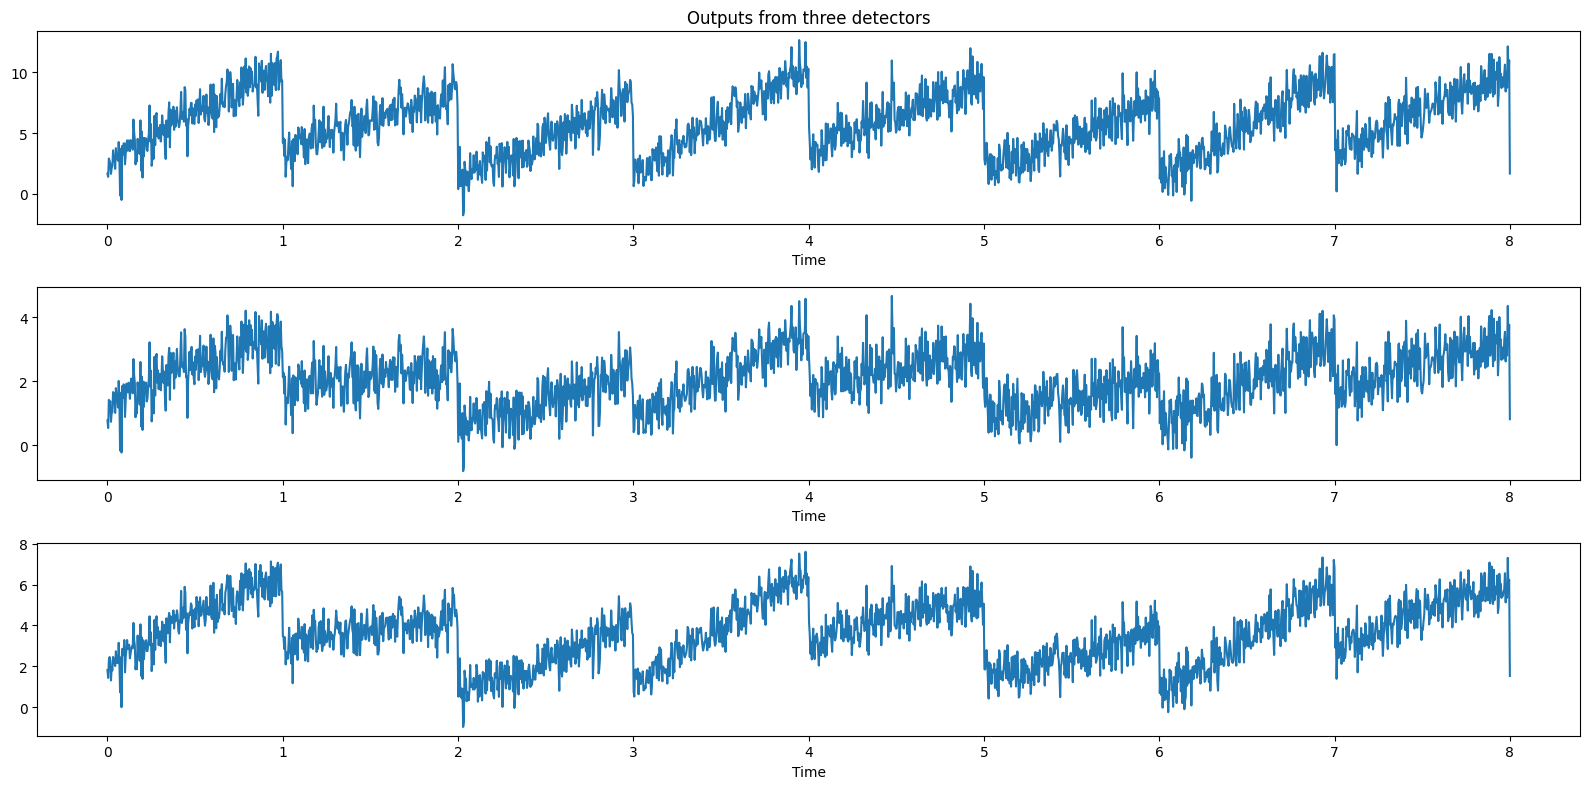

In [9]:
X=np.load('../astroML_data/noisydetector.npy')

time = np.linspace(0, 8, X.shape[0])

fig, axs = plt.subplots(3,figsize=(16,8), tight_layout=True)

for ax,s in zip(axs,X.T):
    ax.plot(time,s)
    ax.set_xlabel('Time')
axs[0].set_title('Outputs from three detectors');


In [16]:
print(X.shape)

(2000, 3)


dataset is 3 dimensional

## PCA components

In [10]:
from sklearn.decomposition import PCA

In [21]:
n=3
pca = PCA(n, svd_solver='randomized')

In [24]:
pca.fit(X)
evals = pca.explained_variance_ratio_
print('Expained fractional variance of data encapsulated in the eigenvalues: ' + str(evals))

Expained fractional variance of data encapsulated in the eigenvalues: [0.97699723 0.01836492 0.00463786]


(2000, 3)
(2000, 3)


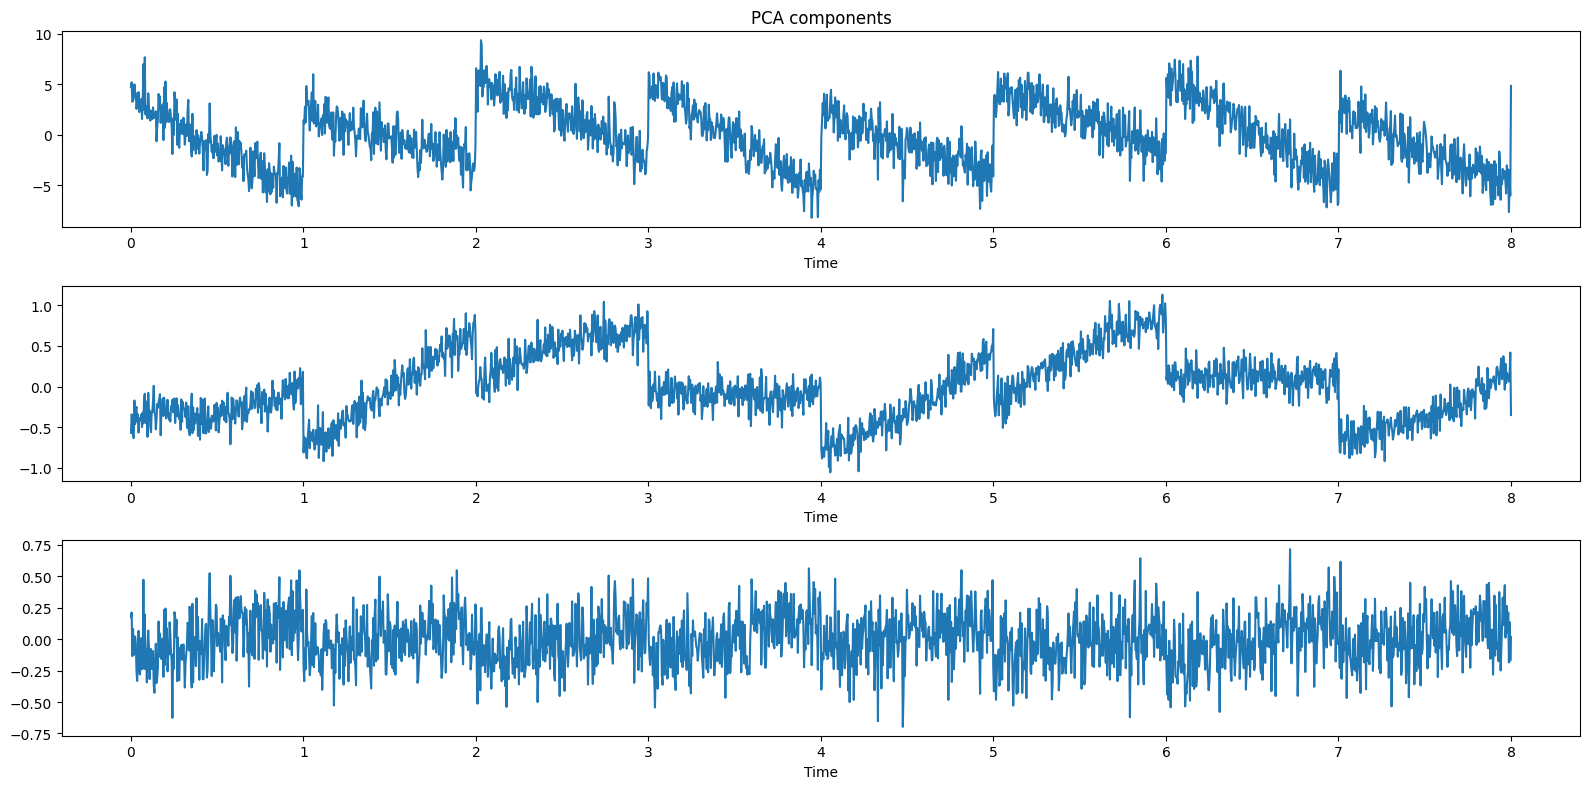

In [28]:
F = pca.fit_transform(X)  # i keep the same dimensions, i'm just recasting the dataset 
                          # on the maximal variance components

print(X.shape)
print(F.shape)

fig, axs = plt.subplots(3,figsize=(16,8), tight_layout=True)

for i,ax in enumerate(axs):
    ax.plot(time, F[:, i])
    ax.set_xlabel('Time')
axs[0].set_title('PCA components');

Even worse, how can i calculate the period with certainty? Plus, this doesn't havbe the functional form of a pulsating star, i would expect some kind of sine function

## ICA components

In [33]:
from sklearn.decomposition import FastICA

In [37]:
n=3
ica = FastICA(n)

In [45]:
I = ica.fit_transform(X)

print(X.shape)
print(I.shape)

(2000, 3)
(2000, 3)


/home/sam/miniconda3/lib/python3.10/site-packages/sklearn/decomposition/_fastica.py:542: FutureWarning: Starting in v1.3, whiten='unit-variance' will be used by default.
  warnings.warn(


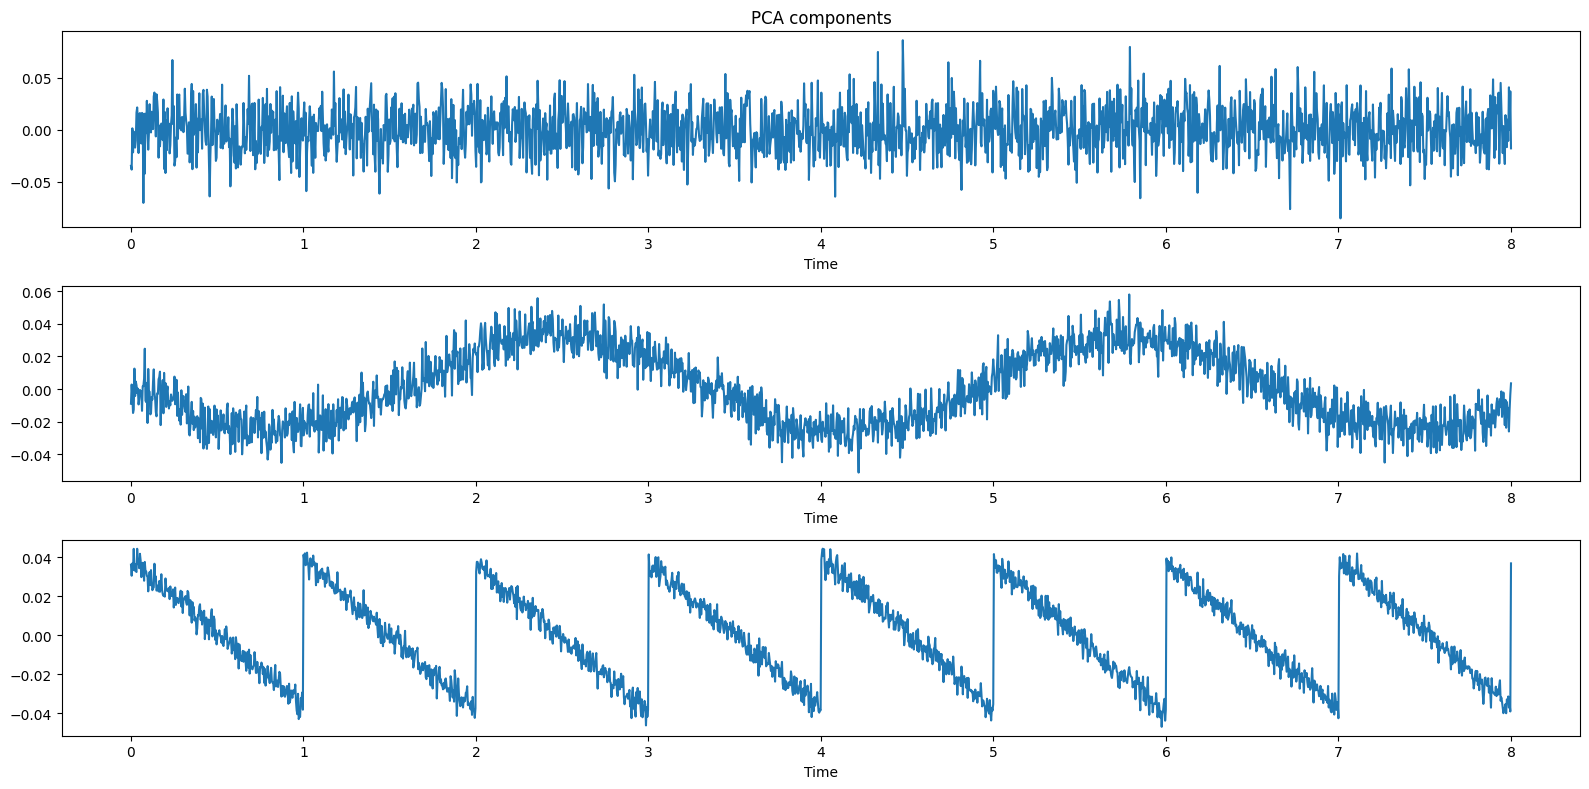

In [46]:
fig, axs = plt.subplots(3,figsize=(16,8), tight_layout=True)

for i,ax in enumerate(axs):
    ax.plot(time, I[:, i])
    ax.set_xlabel('Time')
axs[0].set_title('PCA components');

Much better! you can see by eye that the period is 3! To calculate it i need to fit my signal

In [49]:
signal = I[:,1]

### The frequentist way

In [ ]:
from scipypy.optimize import curve_fit

### The bayesian way

Fitting data by hand

In [167]:
import emcee
import scipy.stats as stats

In [168]:
def sinewave(t, A, w, phi):
    return A*np.sin(w*t + phi)

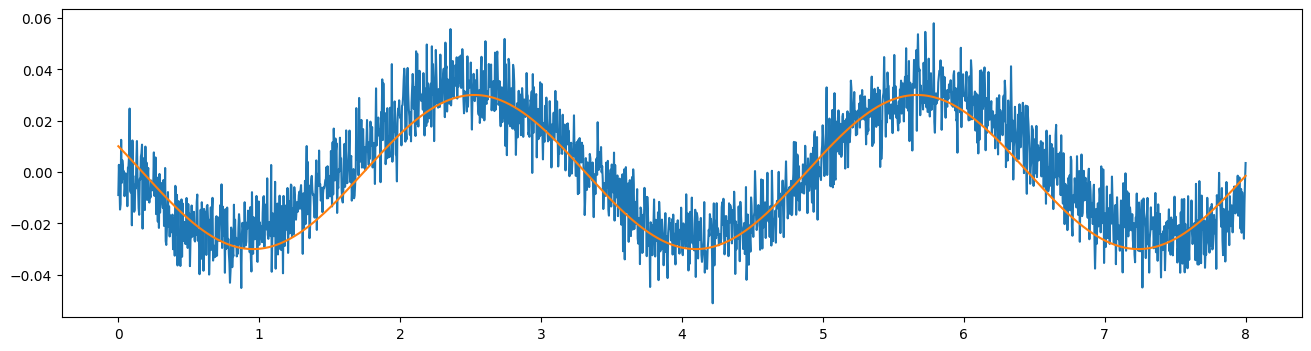

In [169]:
plt.figure(figsize=(16,4))
plt.plot(time, signal)

tt = np.linspace(0,max(time),int(1e3))
plt.plot(tt, sinewave(tt, A=.03, w = 2, phi = 2.8))

what range should i use for $w$? i know $w = 2\pi/T$ so between 0 and 10 should be more than enough

In [170]:
data = np.vstack([time, signal])

In [171]:
def loglikelihood(p, data, model=sinewave):
    #defining my parameters theta = p
    #my points don't have any errors
    A, w, phi = p
    x, y = data
    y_fit = model(x, A, w, phi)
    
    #again we are assuming a gaussian likelihood
    return sum(stats.norm.logpdf(*args) for args in zip(y, y_fit)) #y_fit is the center

In [172]:
def prior(p):
    priors = np.zeros(3)
    priors[0] = stats.uniform.pdf(p[0], loc=0, scale=1)
    priors[1] = stats.uniform.pdf(p[1], loc=0, scale=50)
    priors[2] = stats.uniform.pdf(p[2], loc=0, scale=2*np.pi)
    
    return np.prod(priors)

In [173]:
# emcee wants ln of posterior pdf
def logpost(p, data):
    lp = np.log(prior(p))
    if not np.isfinite(lp):
        return -np.inf
    else:
        return loglikelihood(p, data) + lp #log of the product

In [179]:
import emcee

ndim = 3       # number of parameters in the model
nwalkers = 6  # number of MCMC walkers
nsteps = 1000  # number of MCMC steps to take **for each walker**

In [180]:
# initialize parameters
np.random.seed(1)
starting_guesses = np.zeros([nwalkers, ndim])

for i in range(nwalkers):
    # you want to initialize the guesses at a reasonable value
    starting_guesses[i,0] = 0.03 + 1e-2*np.random.uniform(0,1)
    starting_guesses[i,1] = 2 + 1e-2*np.random.uniform(0,10)
    starting_guesses[i,2] = 2.5 + 1e-2*np.random.uniform(0,np.pi)

print(starting_guesses)

[[0.03417022 2.07203245 2.50000359]
 [0.03302333 2.01467559 2.5029009 ]
 [0.0318626  2.03455607 2.51246482]
 [0.03538817 2.04191945 2.52152681]
 [0.03204452 2.08781174 2.50086041]
 [0.03670468 2.04173048 2.51755176]]


In [181]:
# the function call where all the work happens: 
sampler = emcee.EnsembleSampler(nwalkers, ndim, logpost, args=[data])
sampler.run_mcmc(starting_guesses, nsteps)
print('done')

/tmp/ipykernel_32394/2139065908.py:3: RuntimeWarning: divide by zero encountered in log
  lp = np.log(prior(p))


done


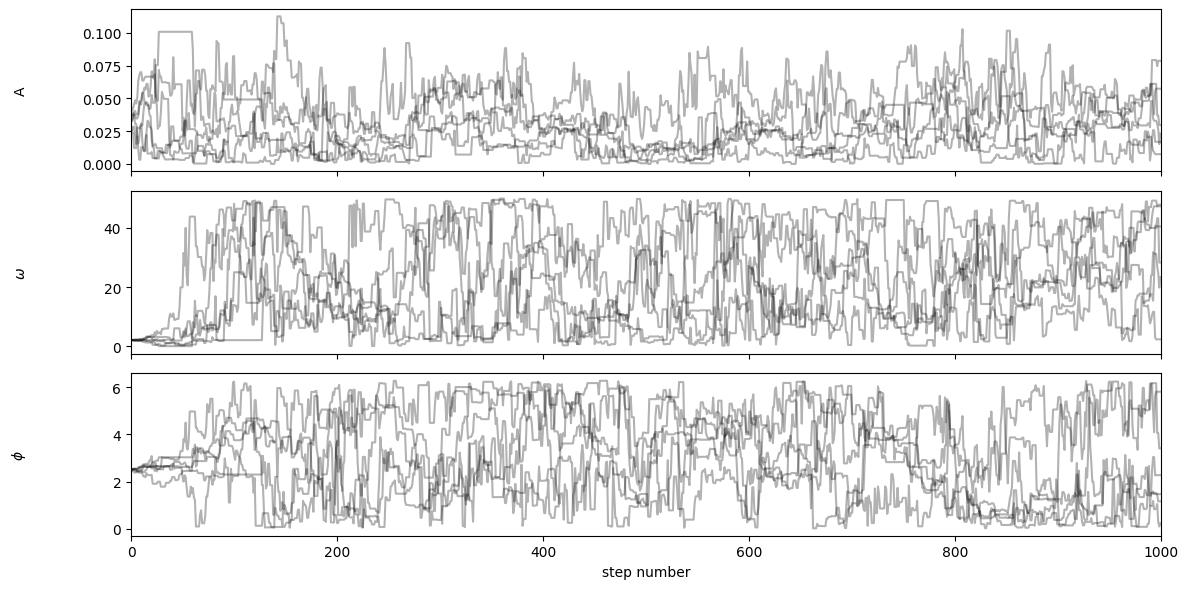

In [182]:
fig, axes = plt.subplots(3, figsize=(12, 6), sharex=True, tight_layout = True)
samples = sampler.get_chain()
labels = [r'A', r'$\omega$', r'$\phi$']

for i in range(ndim):
    ax = axes[i]
    ax.plot(samples[:, :, i], "k", alpha=0.3)
    ax.set_xlim(0, len(samples))
    ax.set_ylabel(labels[i])
    ax.yaxis.set_label_coords(-0.1, 0.5)

axes[-1].set_xlabel("step number");

In [183]:
flat_samples = sampler.get_chain(flat=True)
print(flat_samples.shape)

(6000, 3)


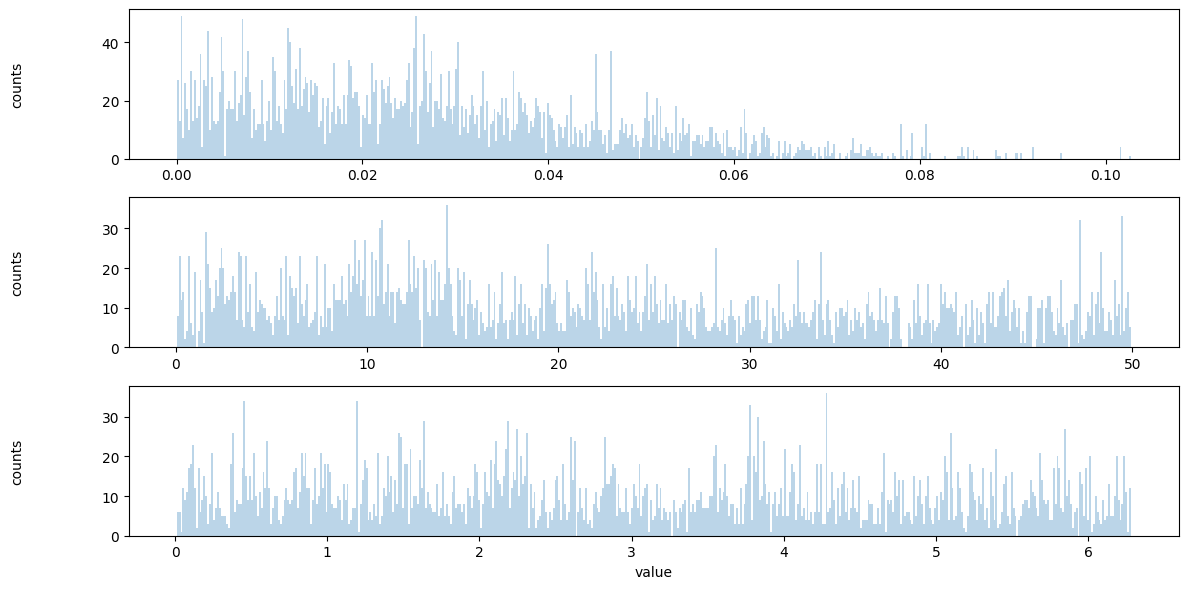

In [184]:
fig, axes = plt.subplots(3, figsize=(12, 6), tight_layout = True)
burn = 1000
w = 0 #walker

for i in range(ndim):
    ax = axes[i]
    ax.hist(flat_samples[burn:, i], bins = 500, alpha=0.3)
    ax.set_ylabel('counts')
    ax.yaxis.set_label_coords(-0.1, 0.5)

axes[-1].set_xlabel("value");

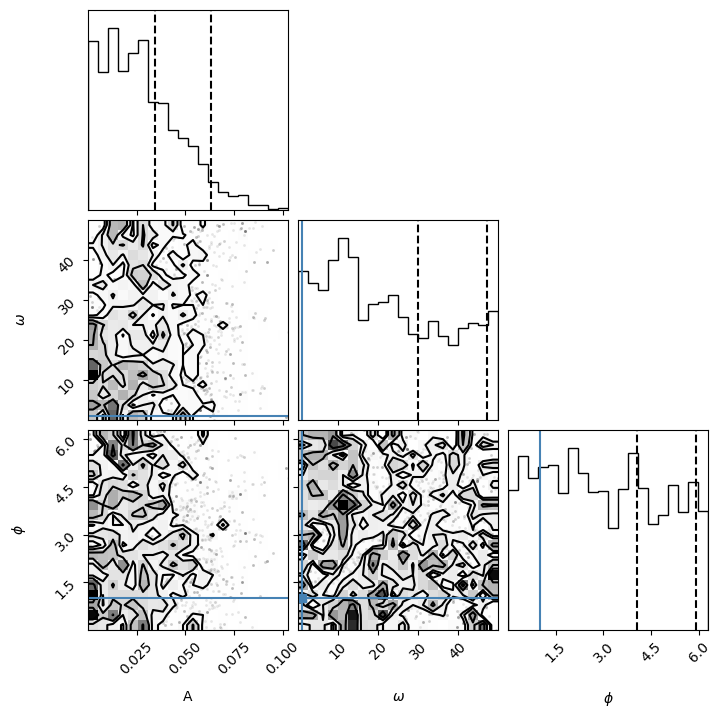

In [185]:
import corner

fb_samples = flat_samples[burn:, :]

fig = corner.corner(
    fb_samples, labels=labels, truths=[1,1,1], quantiles=[.68,.95]
);

(100, 3)


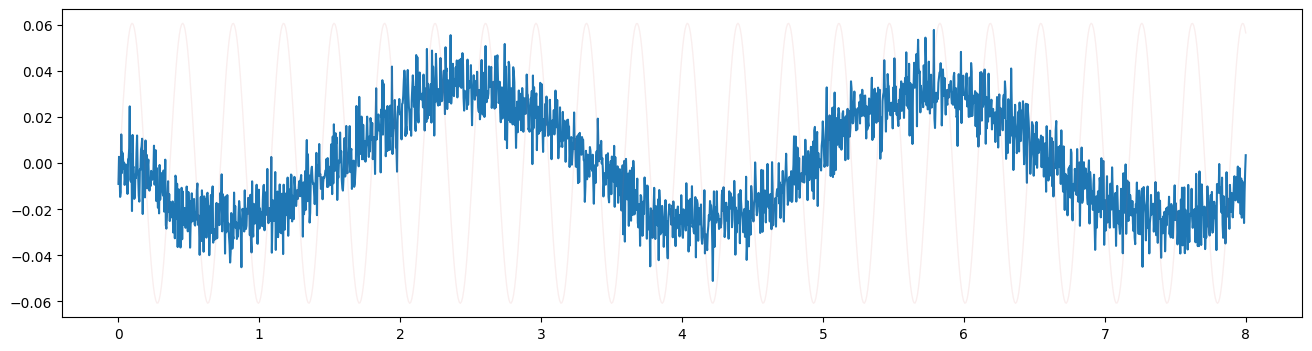

In [186]:
plt.figure(figsize=(16,4))
plt.plot(time, signal)

tt = np.linspace(0,max(time),int(1e3))

p = fb_samples[::round(len(fb_samples)/100), :] #taking the first 100 of each parameter chain
print(p.shape)


plt.plot(tt, sinewave(tt, A=p[-1,0], w=p[-1,1], phi=p[-1,2]), 'indianred', alpha = .1, lw = 1);

In [187]:
import pandas as pd

In [188]:
#the 90% credible region is the interval bw the 5th and 95th percentile, so my error will be 95-5
labels = ['A', r'$\omega$', r'$\phi$']
header = ['med', r'$\sigma_-$', r'$\sigma_+$', r'$\sigma_{90}$']
statistics = [] 

for i,l in enumerate(labels):
    low,med,up = np.percentile(flat_samples[:,i],[5,50,95])
    statistics.append([round(med,3), round(up-med,3), round((low-med)/2,3), round((up-med)/2,3)])

df = pd.DataFrame(statistics, columns=header, index=labels)
display(df)

,med,$\sigma_-$,$\sigma_+$,$\sigma_{90}$
A,0.025,0.042,-0.011,0.021
$\omega$,18.733,28.515,-8.546,14.258
$\phi$,2.834,3.023,-1.243,1.512
